In [84]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['agg.path.chunksize'] = 0
mpl.rcParams.update( mpl.rc_params() )
plt.rcParams.update({'font.size': 18})
#plt.rcParams.update({'text.usetex': True})
plt.rcParams.update({'text.latex.preamble': 'bold'})
plt.rc('font', family='serif')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Layer, Dense, Dropout, MultiHeadAttention, LayerNormalization, Input, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import keras
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from sklearn.metrics import r2_score

import json



## Useful Functions

In [2]:
def split_atg(X1,X,y):
    label_atg,atg,label_no_atg,no_atg = [], [], [], []
    for i in range(len(X)):
        seq = ""
        for j in range(len(X[1])-1):
            seq += X[i][j][0]
        seq += X[i][-1]
        if "ATG" in seq:
            atg.append(X1[i])
            label_atg.append(y[i])
        else:
            no_atg.append(X1[i])
            label_no_atg.append(y[i])
    return np.array(label_atg),np.array(atg),np.array(label_no_atg),np.array(no_atg) 
    

def split_seq_into_words(n, seqs):
    return np.array([" ".join([str(seqs[i][j:j+n]) for j in range(0,len(seqs[i])-n+1)]) for i in range(len(seqs))])
    
def r2(x,y):
    return 1 - sum((x-y)**2)/sum((x-np.mean(x))**2)

def accuracy(x,y):
    return sum(np.exp(-(x-y)**2))/len(x)

## Importing data and splitting into into Traning, Validation and Test Sets

In [3]:
data_path = "Data/GSM3130435_egfp_unmod_1_PREPROCESSED.csv.gz"
df = pd.read_csv(data_path, compression='gzip')
df;

In [4]:
utr = df["utr"].values[:280000]
mrl = df["rl"].values[:280000]

atg_mrl, atg, no_atg_mrl, no_atg = split_atg(utr, utr, mrl)


In [5]:
len(atg), len(no_atg)
l11 = np.array(no_atg)
l12 = np.array(no_atg_mrl)
l21 = np.array(atg)
l22 = np.array(atg_mrl)
l = np.array(utr)
l2 = np.array(mrl)


In [6]:
sentences = np.array([" ".join([str(l[i][j:j+5]) for j in range(0,len(l[i])-4)]) for i in range(len(l))])
label = np.array([l2[i] for i in range(len(l2))])

In [7]:
X_train, X_val, y_train, y_val = train_test_split(sentences, label, test_size=0.2, random_state=25)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=25)

## Building and training the model

In [8]:
max_len = 46
oov_token = '00_V' 
padding_type = 'post'
trunc_type = 'post'  

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
print("Vocab Size: ",vocab_size)

Vocab Size:  1025


In [9]:
token_string = tokenizer.to_json()
with open("trans_RNNA_tokenizer1.json", "w") as file:
    json.dump(token_string, file)


In [10]:
train_temp = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(train_temp, maxlen=max_len, padding=padding_type, truncating=trunc_type)

val_temp = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(val_temp, maxlen=max_len, padding=padding_type, truncating=trunc_type)

test_temp = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(test_temp, maxlen=max_len, padding=padding_type, truncating=trunc_type)

In [12]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, heads, neurons):
        super(TransformerEncoder, self).__init__()
        self.attention = layers.MultiHeadAttention(num_heads=heads, key_dim=embed_dim)
        self.forward = Sequential([layers.Dense(neurons, activation="relu"), layers.Dense(embed_dim),])
        self.dropout1 = layers.Dropout(0.5)
        self.dropout2 = layers.Dropout(0.5)
        self.layernormalization1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernormalization2 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, training):
        att_out = self.attention(inputs, inputs)
        att_out = self.dropout1(att_out, training=training)
        output1 = self.layernormalization1(inputs + att_out)
        fwd_output = self.forward(output1)
        fwd_output = self.dropout2(fwd_output, training=training)
        return self.layernormalization2(output1 + fwd_output)
    
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_embedding = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_embedding = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        pos = tf.range(start=0, limit=maxlen, delta=1)
        pos = self.pos_embedding(pos)
        x = self.token_embedding(x)
        return x + pos


In [13]:
embed_dim = 50
heads = 20
neurons = 32
units=46

inputs = layers.Input(shape=(max_len,))
embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerEncoder(embed_dim, heads, neurons)
x = transformer_block(x)
x = keras.layers.RNN(keras.layers.LSTMCell(units), input_shape=(max_len,))(x)
x = layers.Dense(46, activation="relu")(x)
outputs = layers.Dense(1, activation="linear")(x)
model = Model(inputs=inputs, outputs=outputs)

In [14]:
adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
from sklearn.metrics import r2_score
model.compile(loss='mean_squared_error', optimizer=adam, metrics=[r2_score, accuracy], run_eagerly=True)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 46)]              0         
                                                                 
 token_and_position_embeddin  (None, 46, 50)           53550     
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_encoder (Transf  (None, 46, 50)           206532    
 ormerEncoder)                                                   
                                                                 
 rnn (RNN)                   (None, 46)                17848     
                                                                 
 dense_2 (Dense)             (None, 46)                2162      
                                                             

In [15]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0.001, patience = 1, verbose = 1)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001,
                                           callbacks=[earlystopping])

In [127]:
history = model.fit(X_train,y_train,
                    validation_data=(X_val,y_val),
                    epochs=10,
                    batch_size=128)

Epoch 1/10
1750/1750 [==============================] - 2159s 1s/step - loss: 1.3488 - r2_score: 0.4755 - accuracy: 0.6140 - val_loss: 0.6373 - val_r2_score: 0.7518 - val_accuracy: 0.7361
Epoch 2/10
1750/1750 [==============================] - 2186s 1s/step - loss: 0.5029 - r2_score: 0.8040 - accuracy: 0.7647 - val_loss: 0.4405 - val_r2_score: 0.8289 - val_accuracy: 0.7909
Epoch 3/10
1750/1750 [==============================] - 2102s 1s/step - loss: 0.3982 - r2_score: 0.8449 - accuracy: 0.7968 - val_loss: 0.3832 - val_r2_score: 0.8511 - val_accuracy: 0.8089
Epoch 4/10
1750/1750 [==============================] - 2123s 1s/step - loss: 0.3607 - r2_score: 0.8596 - accuracy: 0.8115 - val_loss: 0.3926 - val_r2_score: 0.8473 - val_accuracy: 0.7935
Epoch 5/10
1750/1750 [==============================] - 1831s 1s/step - loss: 0.3353 - r2_score: 0.8696 - accuracy: 0.8216 - val_loss: 0.3548 - val_r2_score: 0.8621 - val_accuracy: 0.8111
Epoch 6/10
1750/1750 [==============================] - 4012

In [128]:
#model.save('model_trans1')
#model.save('model_trans_6_letters')

INFO:tensorflow:Assets written to: model_trans_6_letters/assets


INFO:tensorflow:Assets written to: model_trans_6_letters/assets


In [16]:
model = keras.models.load_model('model_trans1')

In [17]:
model.summary()

Model: "model_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_60 (InputLayer)       [(None, 46)]              0         
                                                                 
 token_and_position_embeddin  (None, 46, 50)           53550     
 g_59 (TokenAndPositionEmbed                                     
 ding)                                                           
                                                                 
 transformer_encoder_58 (Tra  (None, 46, 50)           206532    
 nsformerEncoder)                                                
                                                                 
 rnn_6 (RNN)                 (None, 46)                17848     
                                                                 
 dense_186 (Dense)           (None, 46)                2162      
                                                          

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Testing the model

In [18]:
predictions = model.predict(X_test).reshape(-1)

875/875 [==============================] - 38s 43ms/step


In [19]:
sentences1 = np.array([" ".join([str(l11[i][j:j+5]) for j in range(0,len(l11[i])-4)]) for i in range(len(l11))])
label_no_atg = np.array([l12[i] for i in range(len(l12))])

sentences2 = np.array([" ".join([str(l21[i][j:j+5]) for j in range(0,len(l21[i])-4)]) for i in range(len(l21))])
label2_atg = np.array([l22[i] for i in range(len(l22))])

In [20]:
sentences1 = sentences1[:15000]
label_no_atg = label_no_atg[:15000]

sentences2 = sentences2[:15000]
label2_atg = label2_atg[:15000]

In [21]:
train_no_atg = tokenizer.texts_to_sequences(sentences1)
X_train_no_atg = pad_sequences(train_no_atg, maxlen=max_len, padding=padding_type, truncating=trunc_type)

train_atg = tokenizer.texts_to_sequences(sentences2)
X_train_atg = pad_sequences(train_atg, maxlen=max_len, padding=padding_type, truncating=trunc_type)

In [22]:
predictions_atg = model.predict(X_train_atg).reshape(-1)


469/469 [==============================] - 20s 42ms/step


In [23]:
predictions_no_atg = model.predict(X_train_no_atg).reshape(-1)

469/469 [==============================] - 20s 42ms/step


/Users/ghadinehme/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/ghadinehme/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


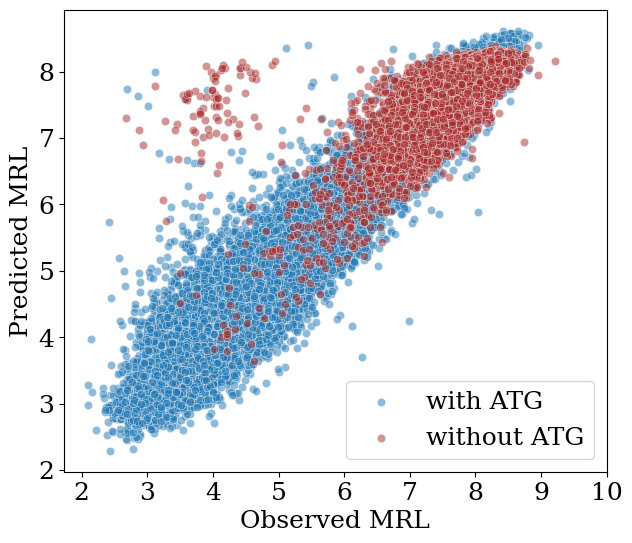

In [94]:
fig = plt.figure(figsize = (7,6))
sns.scatterplot(label2_atg,predictions_atg,linewidth = 0.5, alpha=0.5, label = 'with ATG')
ax = sns.scatterplot(label_no_atg,predictions_no_atg,
                linewidth = 0.5, alpha=0.5, label = 'without ATG', color = "brown", legend = 'auto')

ax.set(xlabel = 'Observed MRL', ylabel = 'Predicted MRL')
plt.xticks([2,3,4,5,6,7,8,9,10])

plt.savefig("Transformer_best.pdf", bbox_inches = "tight")
plt.show()


In [25]:
r2_score(np.concatenate((label_no_atg,label2_atg), axis = None),
         np.concatenate((predictions_no_atg,predictions_atg), axis = None))


0.9403228833562064

In [65]:
labels_class = np.round(np.concatenate((label_no_atg,label2_atg), axis = None))
preds_class = np.round(np.concatenate((predictions_no_atg,predictions_atg), axis = None))


In [66]:
#Confusion matrix of predictions
confusion_matrix = pd.crosstab(labels_class, preds_class, rownames=['Actual'], colnames=['Predicted'])


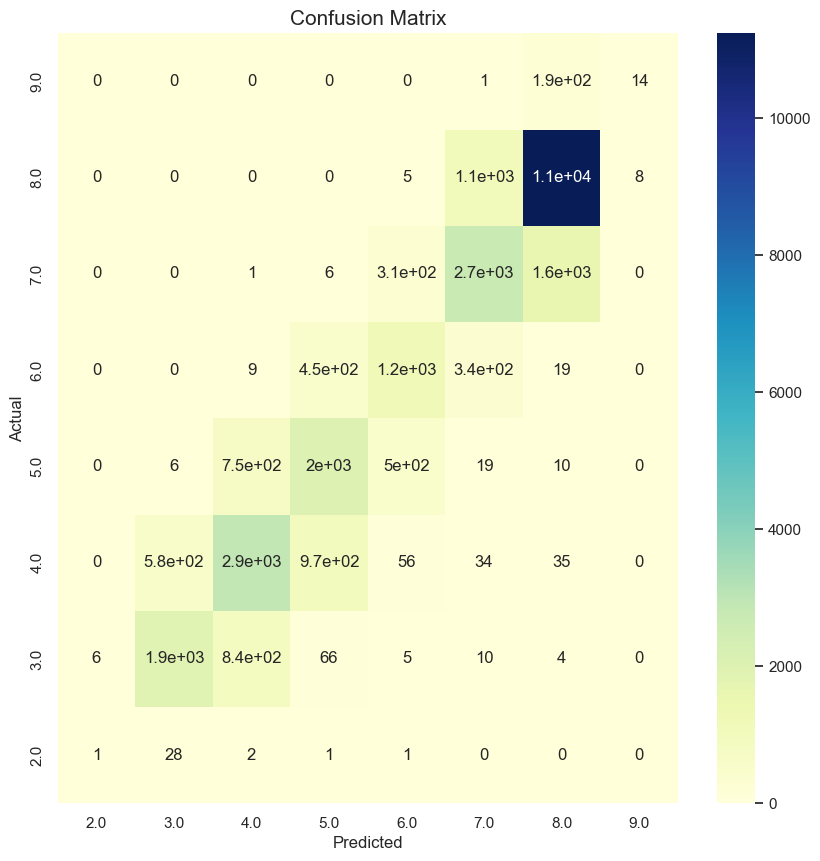

In [69]:
plt.figure(figsize = (10,10))
ax = sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu")
ax.invert_yaxis()
sns.set(font_scale = 1.5)
plt.title("Confusion Matrix", fontsize = 15)
plt.show()